In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install shap

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------- ----------------- 1.6/2.7 MB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 6.6 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   - -------------------------------------- 1.6/38.1 MB 7.6 MB/s eta 0:00:05
   --- ------------------------------------ 3.1/38.1 MB 7.7 MB/s eta 0:00:05
   ----- ---------------------------------- 5.0/38.1 MB 7.9 MB/s eta 0:00:05
   ------- -------------------------------- 6.8/38.1 MB 8.1 MB/s eta 0:00:04
   -------- ------------------------------- 8.1/38.1 MB 7.6 MB/s eta 0:00:04
   ---------- ----------------------------- 9.7/38.1 MB 7.6 MB


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

c:\Users\KIIT0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Set style
sns.set(style="whitegrid")

In [3]:
import os
print(os.getcwd())

c:\Users\KIIT0001\Lti_Project\notebooks


In [4]:
print(os.listdir("../results"))

['cicids_adaptive_model.joblib', 'cicids_results.csv', 'nsl_adaptive_model.joblib', 'nsl_results.csv']


In [9]:
import os

print("NSL file size:", os.path.getsize("../results/nsl_results.csv"), "bytes")
print("CICIDS file size:", os.path.getsize("../results/cicids_results.csv"), "bytes")

NSL file size: 130 bytes
CICIDS file size: 96 bytes


In [10]:
# --------------------------
# 1. Load Results
# --------------------------
nsl_results = pd.read_csv("../results/nsl_results.csv")
cicids_results = pd.read_csv("../results/cicids_results.csv")

print("NSL-KDD Results:")
display(nsl_results.head())

print("CICIDS Results:")
display(cicids_results.head())


NSL-KDD Results:


,window,pre_acc,pre_f1,post_acc,post_f1,retrain_time_s,mem_diff_mb
0,0,0.761,0.749842,0.94,0.936896,0.32,12.44


CICIDS Results:


,window,pre_acc,pre_f1,post_acc,post_f1,retrain_time_s,mem_diff_mb
0,0,1.0,1.0,1.0,1.0,0.62,0.26


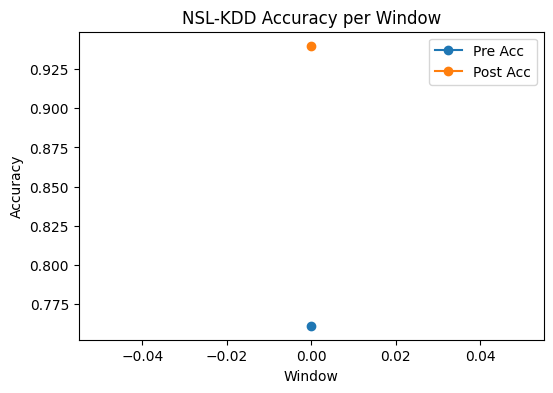

In [11]:
#visual proof of adaptive improvement.
import matplotlib.pyplot as plt

# NSL-KDD
plt.figure(figsize=(6,4))
plt.plot(nsl_results['window'], nsl_results['pre_acc'], label='Pre Acc', marker='o')
plt.plot(nsl_results['window'], nsl_results['post_acc'], label='Post Acc', marker='o')
plt.title('NSL-KDD Accuracy per Window')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

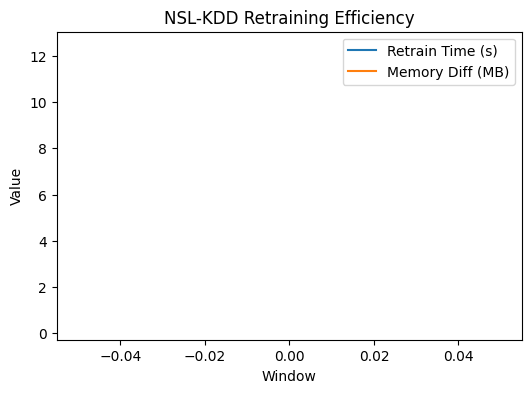

In [12]:
#show efficiency of your adaptive pipeline.
plt.figure(figsize=(6,4))
plt.plot(nsl_results['window'], nsl_results['retrain_time_s'], label='Retrain Time (s)')
plt.plot(nsl_results['window'], nsl_results['mem_diff_mb'], label='Memory Diff (MB)')
plt.title('NSL-KDD Retraining Efficiency')
plt.xlabel('Window')
plt.ylabel('Value')
plt.legend()
plt.show()

In [16]:
import glob

# Recursively find all CSVs in results folder
result_files = glob.glob("../results/**/*.csv", recursive=True)
# Then filter only runtime_summary files
result_files = [f for f in result_files if f.endswith("_runtime_summary.csv")]


In [2]:
import pandas as pd
import glob
import os

# Path to all result CSVs
result_files = glob.glob("../results/*_runtime_summary.csv")

all_results = {}

for file in result_files:
    df = pd.read_csv(file)
    fname = os.path.basename(file).replace('_runtime_summary.csv', '')
    parts = fname.split('_')

    # Auto-detect which part is dataset
    known_datasets = ['nsl', 'cicids', 'NSL', 'CICIDS']
    if parts[0].lower() in known_datasets:
        dataset = parts[0].lower()
        model_name = '_'.join(parts[1:])
    elif parts[-1].lower() in known_datasets:
        dataset = parts[-1].lower()
        model_name = '_'.join(parts[:-1])
    else:
        dataset = 'unknown_dataset'
        model_name = '_'.join(parts)

    # ✅ handle missing model name
    df['model'] = model_name if model_name.strip() != '' else 'unknown_model'
    df['dataset'] = dataset
    all_results[fname] = df

# Combine all results
results_df = pd.concat(all_results.values(), ignore_index=True)

# Verify dataset coverage
print(results_df['dataset'].value_counts())
results_df.head()


dataset
nsl       6
cicids    5
Name: count, dtype: int64


,window,pre_acc,pre_f1,post_acc,post_f1,retrain_time_s,mem_diff_mb,features,model,dataset
0,0,0.999,0.9995,0.981,0.990409,0.67,-1.75,"destination port,max packet length,packet leng...",LogisticRegression,cicids
1,0,1.000,1.0000,1.000,1.000000,0.14,0.20,"destination port,max packet length,packet leng...",RandomForest,cicids
2,0,1.000,1.0000,1.000,1.000000,0.16,-33.29,"bwd packet length mean,avg bwd segment size,pa...",unknown_model,cicids
3,0,1.000,1.0000,1.000,1.000000,0.21,0.43,"destination port,max packet length,packet leng...",SVM,cicids
4,0,1.000,1.0000,1.000,1.000000,0.06,0.24,"destination port,max packet length,packet leng...",XGBoost,cicids


In [3]:
results_df['dataset'] = results_df['dataset'].str.lower()

In [4]:
results_df[['model', 'dataset']].drop_duplicates()

,model,dataset
0,LogisticRegression,cicids
1,RandomForest,cicids
2,unknown_model,cicids
3,SVM,cicids
4,XGBoost,cicids
5,LogisticRegression,nsl
7,RandomForest,nsl
8,unknown_model,nsl
9,SVM,nsl
10,XGBoost,nsl


<Figure size 800x500 with 0 Axes>

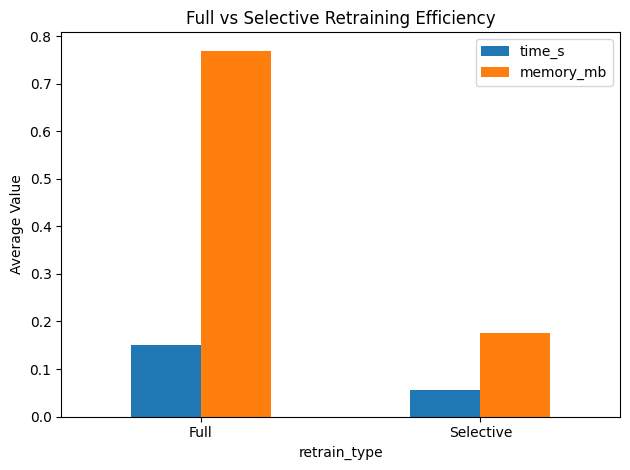

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../results/compare_retraining.csv")

plt.figure(figsize=(8,5))
df.groupby("retrain_type")[["time_s", "memory_mb"]].mean().plot.bar(rot=0)
plt.title("Full vs Selective Retraining Efficiency")
plt.ylabel("Average Value")
plt.tight_layout()
plt.savefig("../results/retraining_efficiency_plot.png", dpi=300)
plt.show()


In [1]:
from scipy.stats import ttest_rel  # or wilcoxon if non-normal

def compare_full_vs_selective(clf_factory, X_ref, y_ref, X_win, y_win, top_k=12, repeats=5):
    times_full, mems_full = [], []
    times_sel, mems_sel = [], []

    for _ in range(repeats):
        # full
        t_full, m_full = measure_retrain_full(clf_factory, X_ref, y_ref, X_win, y_win)
        times_full.append(t_full); mems_full.append(m_full)

        # compute selected features (use same method as pipeline)
        psi_vals = {c: compute_psi(X_ref[c].values, X_win[c].values) for c in X_ref.columns}
        selected = sorted(psi_vals, key=psi_vals.get, reverse=True)[:top_k]

        t_sel, m_sel = measure_retrain_selective(clf_factory, X_ref, y_ref, X_win, y_win, selected)
        times_sel.append(t_sel); mems_sel.append(m_sel)

    # summarize
    def summary(arr): return f"{np.mean(arr):.3f} ± {np.std(arr):.3f}"
    print("Full retrain time:", summary(times_full))
    print("Selective retrain time:", summary(times_sel))
    print("Full mem:", summary(mems_full))
    print("Selective mem:", summary(mems_sel))

    # significance
    t_t, p_t = ttest_rel(times_full, times_sel)
    mem_t, mem_p = ttest_rel(mems_full, mems_sel)
    print(f"paired t-test: time p={p_t:.4f}, memory p={mem_p:.4f}")
